In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [2]:
sp500_ohlc_df = yf.download('^GSPC', start='2016-01-01', end='2022-10-01', interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
clear_sp500_ohlc_df = sp500_ohlc_df.drop(['Open','High','Low','Close','Volume'], axis=1)
clear_sp500_ohlc_df.rename(columns={'Adj Close': 'adjclose'}, inplace = True)
clear_sp500_ohlc_df['adjclose'] = clear_sp500_ohlc_df['adjclose'].round(decimals = 2)

clear_sp500_ohlc_df = clear_sp500_ohlc_df.reset_index().rename(columns={clear_sp500_ohlc_df.index.name:'date'})
clear_sp500_ohlc_df['ts'] = pd.to_datetime(clear_sp500_ohlc_df['date']).astype(np.int64)

In [4]:
clear_sp500_ohlc_df.head(5)

,date,adjclose,ts
0,2015-12-31,2043.94,1451520000000000000
1,2016-01-04,2012.66,1451865600000000000
2,2016-01-05,2016.71,1451952000000000000
3,2016-01-06,1990.26,1452038400000000000
4,2016-01-07,1943.09,1452124800000000000


# Split data into train, validation, and test set

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
features = clear_sp500_ohlc_df[['date', 'ts']]
labels = clear_sp500_ohlc_df['adjclose']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

In [8]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.6
0.2
0.2


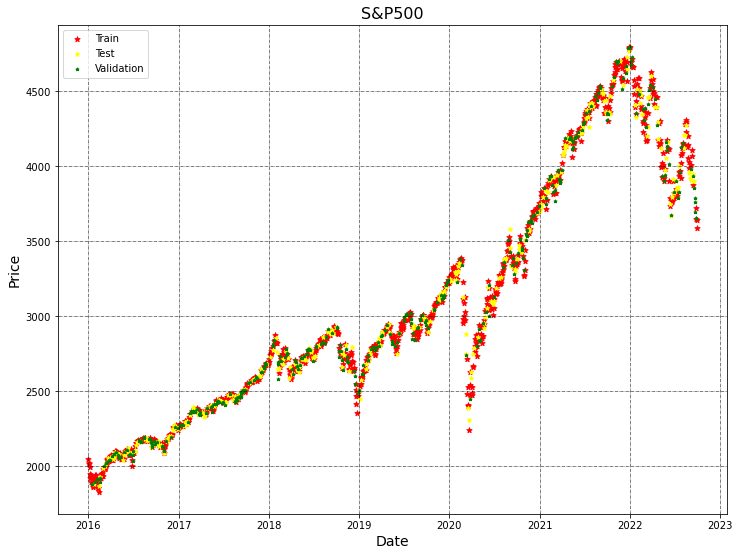

In [9]:
plt.rcParams['figure.figsize'] = [12, 9]
plt.grid(which = 'major', color = 'k', linestyle = '-.', linewidth=0.5)
plt.title('S&P500', fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)


plt.scatter(X_train['date'], y_train, label= 'Train', color= 'red', marker= '*', s=30)
plt.scatter(X_test['date'], y_test, label= 'Test', color= 'yellow', marker= '*', s=20)
plt.scatter(X_val['date'], y_val, label= 'Validation', color= 'green', marker= '*', s=10)

plt.legend()
plt.show()

# Write out all data

In [10]:
X_train.to_csv('train_features.csv', index=False, header=False)
X_val.to_csv('val_features.csv', index=False, header=False)
X_test.to_csv('test_features.csv', index=False, header=False)

y_train.to_csv('train_labels.csv', index=False, header=False)
y_val.to_csv('val_labels.csv', index=False, header=False)
y_test.to_csv('test_labels.csv', index=False, header=False)

# Linear Regression: Fit and evaluate a model

In [11]:
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Reading training data 

In [12]:
tr_features = pd.read_csv('train_features.csv', header=None)
tr_features = tr_features.iloc[:,1].values.reshape(-1,1)

tr_labels = pd.read_csv('train_labels.csv', header=None)

In [13]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [14]:
lr = LinearRegression()
parameters = {
    'fit_intercept':[True,False], 
    'normalize':[True,False], 
    'copy_X':[True, False]
}

cv = GridSearchCV(lr, parameters, cv=5)
cv.fit(tr_features, tr_labels)

print_results(cv)

BEST PARAMS: {'copy_X': True, 'fit_intercept': True, 'normalize': True}

0.867 (+/-0.045) for {'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.867 (+/-0.045) for {'copy_X': True, 'fit_intercept': True, 'normalize': False}
0.258 (+/-0.017) for {'copy_X': True, 'fit_intercept': False, 'normalize': True}
0.258 (+/-0.017) for {'copy_X': True, 'fit_intercept': False, 'normalize': False}
0.867 (+/-0.045) for {'copy_X': False, 'fit_intercept': True, 'normalize': True}
0.867 (+/-0.045) for {'copy_X': False, 'fit_intercept': True, 'normalize': False}
0.258 (+/-0.017) for {'copy_X': False, 'fit_intercept': False, 'normalize': True}
0.258 (+/-0.017) for {'copy_X': False, 'fit_intercept': False, 'normalize': False}


# Write out TRAIN model

In [15]:
joblib.dump(cv.best_estimator_, 'LinearRegression_model.pkl')

['LinearRegression_model.pkl']

# LinearSVR: Fit and evaluate a model

In [16]:
from sklearn.svm import LinearSVR

In [17]:
linear_svr = LinearSVR()
parameters = {
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'C': [0.1, 1, 10]
}

cv = GridSearchCV(linear_svr, parameters, cv=5)
cv.fit(tr_features, tr_labels)

print_results(cv)

BEST PARAMS: {'C': 0.1, 'loss': 'epsilon_insensitive'}

-15.471 (+/-2.117) for {'C': 0.1, 'loss': 'epsilon_insensitive'}
-15.471 (+/-2.117) for {'C': 0.1, 'loss': 'squared_epsilon_insensitive'}
-15.471 (+/-2.117) for {'C': 1, 'loss': 'epsilon_insensitive'}
-15.471 (+/-2.117) for {'C': 1, 'loss': 'squared_epsilon_insensitive'}
-15.471 (+/-2.117) for {'C': 10, 'loss': 'epsilon_insensitive'}
-15.471 (+/-2.117) for {'C': 10, 'loss': 'squared_epsilon_insensitive'}


In [18]:
cv.best_estimator_

LinearSVR(C=0.1)

# Write out TRAIN model

In [19]:
joblib.dump(cv.best_estimator_, 'LinearSVR_model.pkl')

['LinearSVR_model.pkl']

# MLPRegressor: Fit and evaluate a model

In [20]:
from sklearn.neural_network import MLPRegressor

In [21]:
mlp_regression = MLPRegressor()
parameters = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['identity', 'relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

cv = GridSearchCV(mlp_regression, parameters, cv=5)
cv.fit(tr_features, tr_labels)

print_results(cv)

BEST PARAMS: {'activation': 'identity', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

-8.434971646534769e+18 (+/-3.3739886586139075e+19) for {'activation': 'identity', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
-8.390306029082986e+17 (+/-3.3561224116331945e+18) for {'activation': 'identity', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
-2.3698301017986668e+16 (+/-9.479320407194667e+16) for {'activation': 'identity', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.257 (+/-0.026) for {'activation': 'identity', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.232 (+/-0.085) for {'activation': 'identity', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
-0.214 (+/-1.155) for {'activation': 'identity', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
-0.604 (+/-3.418) for {'activation': 'identity', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
-0.128 (+/-0.992) for {'activation': 'identity', '

In [22]:
cv.best_estimator_

MLPRegressor(activation='identity', hidden_layer_sizes=(50,))

In [23]:
joblib.dump(cv.best_estimator_, 'MLPRegressor_model.pkl')

['MLPRegressor_model.pkl']

# Read Testing and Validation data

In [24]:
val_features = pd.read_csv('val_features.csv', header=None)
val_features = val_features.iloc[:,1].values.reshape(-1,1)
val_labels = pd.read_csv('val_labels.csv', header=None)

te_features = pd.read_csv('test_features.csv', header=None)
te_features = te_features.iloc[:,1].values.reshape(-1,1)
te_labels = pd.read_csv('test_labels.csv', header=None)

# Read in Models

In [25]:
models = {}

for mdl in ['LinearRegression', 'LinearSVR', 'MLPRegressor']:
    models[mdl] = joblib.load('{}_model.pkl'.format(mdl))

In [26]:
models

{'LinearRegression': LinearRegression(normalize=True),
 'LinearSVR': LinearSVR(C=0.1),
 'MLPRegressor': MLPRegressor(activation='identity', hidden_layer_sizes=(50,))}

In [27]:
def evaluate_model(name, model, features, labels):
    score = model.score(features, labels)
    print('{} -- Score: {}'.format(name, score))

In [29]:
for name, mdl in models.items():
    evaluate_model(name, mdl, val_features, val_labels)

LinearRegression -- Score: 0.8834777353963266
LinearSVR -- Score: -15.844494539213233
MLPRegressor -- Score: 0.26496392544527325


# Best model validation data

In [30]:
evaluate_model('LinearRegression', models['LinearRegression'], te_features, te_labels)

LinearRegression -- Score: 0.8816760951354526
